In [1]:
import numpy as np
import scipy
from scipy.sparse.linalg import expm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.widgets import Slider, CheckButtons

import networkx as nx
from networkx import hypercube_graph, star_graph
from networkx.drawing.nx_agraph import graphviz_layout

### Functions to implement Classical and Quantum Random Walks

In [2]:
# Random Walk on A
def random_walk(A, t=0):
    L = A.copy()
    for i in range(A.shape[0]):
        L[i,i] = -len(A[[i], :].nonzero()[0])
    # Set initial location to be "0" node
    p0 = np.zeros(L.shape[0])
    p0[0] = 1
    pt = expm(L*t) @ p0
    return pt

# Quantum Walk on A
def quantum_walk(A, t=0):
    # Set initial location to be "0" node
    psi0 = np.zeros(A.shape[0])
    psi0[0] = 1
    psit = expm(-1j * A *t) @ psi0
    return psit

# Define a custom colormap from gray to pink
cmap = LinearSegmentedColormap.from_list(
    'CustomMap',
    ['gray', 'purple']
)
def draw_walk(G, pvec:np.ndarray, ax, vrange=(0,1), cmap=cmap):
    # Colormap
    norm = Normalize(vmin=vrange[0], vmax=vrange[1])
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

    nx.draw_networkx(
        G,
        ax=ax, 
        pos=graphviz_layout(G, prog="dot"), 
        node_color=[mapper.to_rgba(pvec[i]) for i in range(len(pvec))], 
        node_size=250, 
        with_labels=False
    )
    plt.show()

Visualizing Graph using <code>networkx</code> package

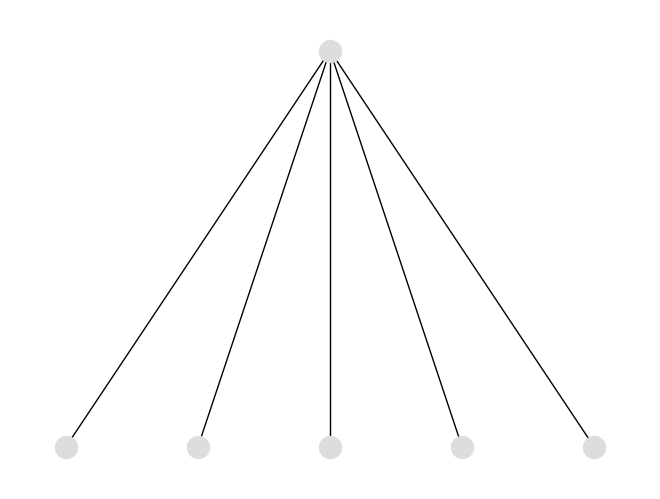

In [5]:
%matplotlib inline
n=5
G = star_graph(n)
A = scipy.sparse.csc_matrix(nx.adjacency_matrix(G))
# Draw graph
nx.draw(G, pos=graphviz_layout(G, prog="dot"), node_color="#dddddd", node_size=250, with_labels=False)
plt.show()

## Comparing Both Walks
For a graph $G$ with adjacency matrix $A$, the interactive plot will draw the random and quantum walks, as well as the difference in probability between them.
- when <code>sync times</code> option is selected, it will use the "shared" time slider for all 3 plots
- when the option is not selected, it will use the "random" and "quantum" sliders for the respective plots, and then draw the difference plot from those times.

In [6]:
%matplotlib qt
fig, axs = plt.subplot_mosaic([
    ['C', 'C', 'Q', 'Q'],
    ['.', 'B', 'B', '.']
])

# Button to sync walks
is_synced = False
rax = fig.add_axes([0.0, 0.0, 0.1, 0.1])
check = CheckButtons(
    ax=rax,
    labels=['Sync Times'],
    actives=[is_synced],
    label_props={'color':'black'},
    frame_props={'edgecolor':'black'},
    check_props={'facecolor':'black'},
)
def callback(val):
    is_synced = check.get_status()[0]
    # If selected, draw synced plots, otherwise, draw separately
    if is_synced:
        prand_vec = random_walk(A, time_slider.val)
        pquant_vec = np.abs(quantum_walk(A, time_slider.val))**2
    else:
        prand_vec = random_walk(A, rand_time_slider.val)
        pquant_vec = np.abs(quantum_walk(A, quantum_time_slider.val))**2

    # Draw random
    draw_walk(G, prand_vec, axs['C'])
    # Draw quantum
    draw_walk(G, pquant_vec, axs['Q'])
    # Draw diff
    pDiff = pquant_vec - prand_vec
    draw_walk(G, pDiff, axs['B'], vrange=(-1, 1), cmap=cm.seismic)

check.on_clicked(callback)

## Random Walk
# Draw the initial probs
prand_vec = random_walk(A, 0)
draw_walk(G, prand_vec, axs['C'])

# Slider
rand_axtime = fig.add_axes([0.16, 0.5, 0.3, 0.03])
rand_time_slider = Slider(ax=rand_axtime, label='random', valmin=0, valmax=5, valinit=0)

# Update random and diff plots if slider moves
def update_random(val):
    is_synced = check.get_status()[0]
    # Only draw if not synced
    if not is_synced:
        # Draw the new random probs
        prand_vec = random_walk(A, val)
        draw_walk(G, prand_vec, axs['C'])

        # Draw the Difference plot with the selected random time
        pDiff = np.abs(quantum_walk(A, quantum_time_slider.val))**2 - prand_vec
        draw_walk(G, pDiff, axs['B'], vrange=(-1, 1), cmap=cm.seismic)

        fig.canvas.draw_idle()
rand_time_slider.on_changed(update_random)


## Quantum Walk
# Draw the initial probs
pquant_vec = np.abs(quantum_walk(A, 0))**2
draw_walk(G, pquant_vec, axs['Q'])

quantum_axtime = fig.add_axes([0.56, 0.5, 0.3, 0.03])
quantum_time_slider = Slider(ax=quantum_axtime, label='quantum', valmin=0, valmax=5, valinit=0)

def update_quantum(val):
    is_synced = check.get_status()[0]
    if not is_synced:
        # Draw the new quantum probs
        pquant_vec = np.abs(quantum_walk(A, val))**2
        draw_walk(G, pquant_vec, axs['Q'])
        
        # Draw the Difference plot with the selected random time
        pDiff = pquant_vec - random_walk(A, rand_time_slider.val)
        draw_walk(G, pDiff, axs['B'], vrange=(-1, 1), cmap=cm.seismic)

        fig.canvas.draw_idle()
quantum_time_slider.on_changed(update_quantum)


## Difference
# Draw the initial probs
pDiff = np.abs(quantum_walk(A))**2 - random_walk(A)
draw_walk(G, pDiff, axs['B'], vrange=(-1, 1), cmap=cm.seismic)

axtime = fig.add_axes([0.15, 0.05, 0.75, 0.03])
time_slider = Slider(ax=axtime, label='shared', valmin=0, valmax=5, valinit=0)


def update(val):
    is_synced = check.get_status()[0]
    # Only draw if synced
    if is_synced:
        # Draw random
        prand_vec = random_walk(A, val)
        draw_walk(G, prand_vec, axs['C'])
        
        # Draw quantum
        pquant_vec = np.abs(quantum_walk(A, val))**2
        draw_walk(G, pquant_vec, axs['Q'])

        # Draw diff
        pDiff = pquant_vec - prand_vec
        draw_walk(G, pDiff, axs['B'], vrange=(-1, 1), cmap=cm.seismic)

        fig.canvas.draw_idle()

time_slider.on_changed(update)

plt.show()

## Each Walk Individually

### Classical Random Walk

Note that even for irregular graphs, the steady state probability vector is the uniform vector $(1,\dots, 1)/|V|$.

In [ ]:
%matplotlib qt

fig, ax = plt.subplots()

pvec = random_walk(A, 0)
draw_walk(G, pvec, ax)

axtime = fig.add_axes([0.15, 0.05, 0.75, 0.03])
time_slider = Slider(
    ax=axtime,
    label='time',
    valmin=0,
    valmax=5,
    valinit=0,
)

# The function to be called anytime a slider's value changes
def update(val):
    pvec = random_walk(A, val)
    draw_walk(G, pvec, ax)
    fig.canvas.draw_idle()


# Register the update function with each slider
time_slider.on_changed(update)

plt.show()

### Quantum Walk

In [ ]:
%matplotlib qt

fig, ax = plt.subplots()

pvec = np.abs(quantum_walk(A, 0))**2
draw_walk(G, pvec, ax)

axtime = fig.add_axes([0.15, 0.05, 0.75, 0.03])
time_slider = Slider(
    ax=axtime,
    label='time',
    valmin=0,
    valmax=5,
    valinit=0,
)

# The function to be called anytime a slider's value changes
def update(val):
    pvec = np.abs(quantum_walk(A, val))**2
    draw_walk(G, pvec, ax)
    fig.canvas.draw_idle()


# Register the update function with each slider
time_slider.on_changed(update)

plt.show()

## Difference between the 2 Methods
With the <code>cm.seismic</code> colormap,
- Red means *Quantum Walk* will find the node with greater probability
- Blue means *random walk* will find the node with greater probability

In [ ]:
%matplotlib qt

fig, ax = plt.subplots()

pDiff = np.abs(quantum_walk(A))**2 - random_walk(A)
draw_walk(G, pDiff, ax, vrange=(-1, 1), cmap=cm.seismic)

axtime = fig.add_axes([0.15, 0.05, 0.75, 0.03])
time_slider = Slider(
    ax=axtime,
    label='time',
    valmin=0,
    valmax=5,
    valinit=0,
)

# The function to be called anytime a slider's value changes
def update(val):
    pDiff = np.abs(quantum_walk(A, val))**2 - random_walk(A, val)
    draw_walk(G, pDiff, ax, vrange=(-1, 1), cmap=cm.seismic)
    fig.canvas.draw_idle()

# Register the update function with each slider
time_slider.on_changed(update)

plt.show()

In [ ]:
times = np.arange(0, 5, 0.01)
prand_vec_middle = np.zeros(times.shape[0])
prand_vec_leaf = np.zeros(times.shape[0])
pquant_vec_middle = np.zeros(times.shape[0])
pquant_vec_leaf = np.zeros(times.shape[0])

for i, t in enumerate(times):
    rand = random_walk(A, t)
    quant = quantum_walk(A, t)
    prand_vec_middle[i] = rand[0]
    pquant_vec_middle[i] = np.abs(quant[0])**2
    prand_vec_leaf[i] = rand[-1]
    pquant_vec_leaf[i] = np.abs(quant[-1])**2
    

c:\Users\akyap\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


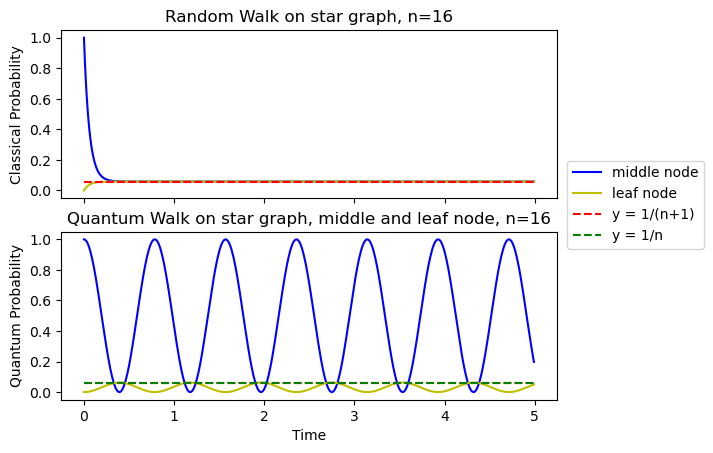

In [117]:
%matplotlib inline
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(times, prand_vec_middle, 'b-')
ax[0].plot(times, prand_vec_leaf, 'y-')
ax[0].plot([0, 5], [1/(n+1), 1/(n+1)], 'r--')
ax[0].set_ylabel("Classical Probability")
ax[0].set_title(f"Random Walk on star graph, n={n}")
ax[1].plot(times, pquant_vec_middle, 'b-', label='middle node')
ax[1].plot(times, pquant_vec_leaf, 'y-', label='leaf node')
ax[1].plot([0, 5], [1/(n+1), 1/(n+1)], 'r--', label='y = 1/(n+1)')
ax[1].plot([0, 5], [1/(n), 1/(n)], 'g--', label='y = 1/n')
ax[1].set_ylabel("Quantum Probability")
ax[1].set_title(f"Quantum Walk on star graph, middle and leaf node, n={n}")

ax[1].set_xlabel("Time")
ax[1].legend(bbox_to_anchor=(1.02, 0.9), loc='lower left', borderaxespad=0.)
plt.show()

In [ ]:
3.14
2.21
1.8
1.58
0.78

1.58